In [61]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
from src import utils, nlp_utils
from bs4 import BeautifulSoup
import itertools

import nltk
from nltk.corpus import stopwords

from datetime import datetime
from wordcloud import WordCloud

In [3]:
# nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\morga\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Wall Street Forum

## EDA - Raw Data

In [4]:
wallstreet = pd.read_csv('data/wallstreet.csv')

In [5]:
wallstreet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45372 entries, 0 to 45371
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   postID                45372 non-null  int64 
 1   threadID              45372 non-null  int64 
 2   threadTitle           45370 non-null  object
 3   URL                   45372 non-null  object
 4   subforum              45372 non-null  object
 5   authorName            45372 non-null  object
 6   postAuthorMembership  45372 non-null  object
 7   postAuthorJoinDate    45372 non-null  object
 8   authorReputation      45372 non-null  int64 
 9   postDate              45372 non-null  object
 10  postSequence          45372 non-null  int64 
 11  likes                 45372 non-null  int64 
 12  flatContent           45372 non-null  object
 13  contentWithHTMLTag    45372 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.8+ MB


In [6]:
total_num_posts_wall = wallstreet.shape[0] 
print('# of Postings: ', total_num_posts_wall)
print('# of Unique Threads : ', len(wallstreet['threadID'].unique()))
print('# of Unique Subforums : ', len(wallstreet['subforum'].unique()))
print('# of Unique Authors : ', len(wallstreet['authorName'].unique()))
print('# of Membership Types : ', len(wallstreet['postAuthorMembership'].unique()))

# of Postings:  45372
# of Unique Threads :  8755
# of Unique Subforums :  40
# of Unique Authors :  5533
# of Membership Types :  8


In [7]:
wall_authors = pd.DataFrame(wallstreet['authorName'].value_counts()).reset_index()
wall_authors.columns = ['author','num_postings']
wall_authors['prcnt_total_posts'] = wall_authors['num_postings'] / total_num_posts_wall
wall_authors.head(10)

,author,num_postings,prcnt_total_posts
0,med3l1n,4889,0.107754
1,6LACK,1500,0.033060
2,leaguemode,1146,0.025258
3,ExpectUS,1113,0.024531
4,PurityRing,1111,0.024486
5,BonesKoopa,476,0.010491
6,Icepapi,446,0.009830
7,code48k,379,0.008353
8,deusxmacina,354,0.007802
9,dabbingtimes,334,0.007361


In [8]:
wall_threads = pd.DataFrame(wallstreet['threadTitle'].value_counts()).reset_index()
wall_threads.columns = ['thread_topic','num_postings']
wall_threads['prcnt_total_posts'] = wall_threads['num_postings'] / total_num_posts_wall
wall_threads.head(10)

,thread_topic,num_postings,prcnt_total_posts
0,GozNym 2.0 Banking Bot (Page 2 of 3),75,0.001653
1,GozNym 2.0 Banking Bot (Page 1 of 3),75,0.001653
2,[Price & Version update] BTC ATM Malware,73,0.001609
3,GozNym 2.0 Banking Bot (Page 3 of 3),56,0.001234
4,Hello,52,0.001146
5,ANZ AU Bank accounts with security Q&A! (Page ...,50,0.001102
6,US Tax Refund: 2018 Tax W2 Forms With AGI & DO...,50,0.001102
7,ANZ AU Bank accounts with security Q&A! (Page ...,50,0.001102
8,US Tax Refund: 2018 Tax W2 Forms With AGI & DO...,50,0.001102
9,CASHAPP GUIDE,50,0.001102


In [9]:
wall_subforums = pd.DataFrame(wallstreet['subforum'].value_counts()).reset_index()
wall_subforums.columns = ['subforum','num_postings']
wall_subforums['prcnt_total_posts'] = wall_subforums['num_postings'] / total_num_posts_wall
wall_subforums.head(10)

,subforum,num_postings,prcnt_total_posts
0,Fraud,12277,0.270585
1,General Questions,5225,0.115159
2,Carding Stuff,3836,0.084546
3,Services,2973,0.065525
4,Cannabis,2431,0.053579
5,Introductions,2418,0.053293
6,Counterfeits,1727,0.038063
7,Stimulants,1537,0.033876
8,Announcements,1507,0.033214
9,Digital goods,1443,0.031804


In [10]:
wall_joindate = pd.DataFrame(wallstreet['postAuthorJoinDate'].value_counts()).reset_index()
wall_joindate.columns = ['join_date','count']
wall_joindate['prcnt_total_posts'] = wall_joindate['count'] / total_num_posts_wall
wall_joindate.head(10)

,join_date,count,prcnt_total_posts
0,Despacitoland,4889,0.107754
1,G,1500,0.033060
2,2017-11-06,1227,0.027043
3,2018-01-10,1146,0.025258
4,InterWebz,1113,0.024531
5,2017-07-27,524,0.011549
6,2018-03-03,498,0.010976
7,2017-11-09,427,0.009411
8,2018-05-06,415,0.009147
9,2017-10-17,403,0.008882


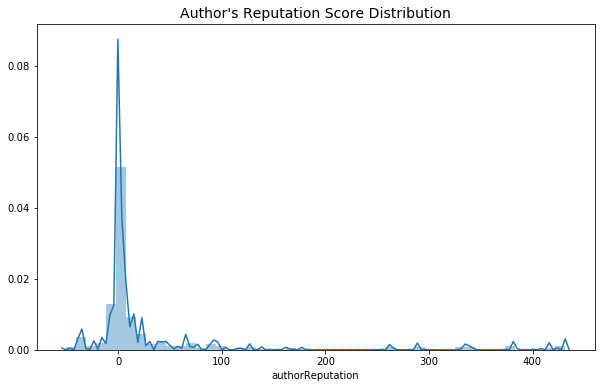

In [11]:
# Max value ~ 5,400.
constraint = 500
reputation = wallstreet[wallstreet['authorReputation'] < constraint]['authorReputation']
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.distplot(reputation)
ax.set_title("Author's Reputation Score Distribution", fontsize=14);

C:\Users\morga\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


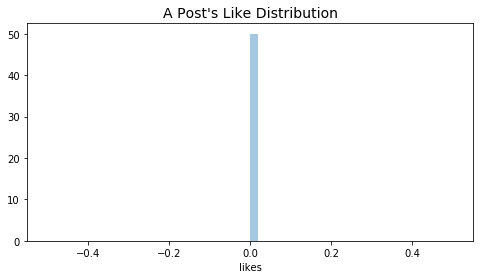

In [12]:
constraint = 100
likes = wallstreet[wallstreet['likes'] < constraint]['likes']
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.distplot(likes)
ax.set_title("A Post's Like Distribution", fontsize=14);

---
## Data Processing / Feature Engineering

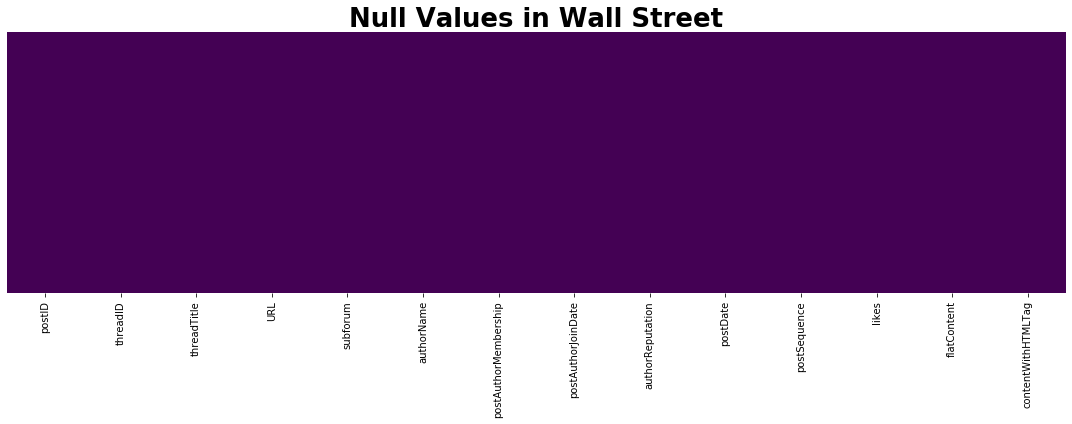

In [15]:
utils.plot_null_val_heatmap(wallstreet, 'Null Values in Wall Street', (15,6))

In [16]:
wallstreet_v2 = wallstreet.copy()

In [18]:
wallstreet_v2['post_date_dt'] = wallstreet_v2['postDate'].apply(utils.fix_postdate_col)
wallstreet_v2['author_join_date'] = wallstreet_v2.apply(lambda x: utils.fix_author_join_date_col(x['postAuthorJoinDate'], x['postAuthorMembership'], x['post_date_dt']), axis=1)
wallstreet_v2['num_days_member_when_posted'] = wallstreet_v2['post_date_dt'].dt.date - wallstreet_v2['author_join_date'].dt.date
wallstreet_v2['num_days_member_when_posted'] = wallstreet_v2['num_days_member_when_posted'].dt.days

In [19]:
cols_to_drop = ['URL', 'likes', 'postDate', 'postAuthorJoinDate']
wallstreet_v2.drop(cols_to_drop, axis=1, inplace=True)

---
# EDA using Engineering Features

In [56]:
def clean_parse_text(text):
    '''
   
    Args:
        
        
    Return:
        
    '''
    #punc = '''!()-[]{};:'"\, <>./?@#$%^&*_~'''
    text = BeautifulSoup(text, 'html.parser').get_text().lower()
    text = re.sub(r'\n', ' ', text)
    # test_str.replace(ele, "")  
    text = re.sub(r"[^\w\s]", '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    tokens = nltk.word_tokenize(text)
    
    return tokens

In [63]:
def prep_text_for_wordcloud(text):
    '''
   
    Args:
        
        
    Return:
        
    '''
    #punc = '''!()-[]{};:'"\, <>./?@#$%^&*_~'''
    text = BeautifulSoup(text, 'html.parser').get_text().lower()
    text = re.sub(r'\n', ' ', text)
    # test_str.replace(ele, "")  
    text = re.sub(r"[^\w\s]", '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t not in stopwords.words('english')]
    joined_tokens = ' '.join(tokens)
    
    return joined_tokens

In [62]:
wall_nlp = pd.read_csv('data/wall_nlp.csv')

In [ ]:
wall_nlp['wordcloud_text'] = wall_nlp['contentWithHTMLTag'].apply(prep_text_for_wordcloud)

In [ ]:
wall_nlp.head(10)

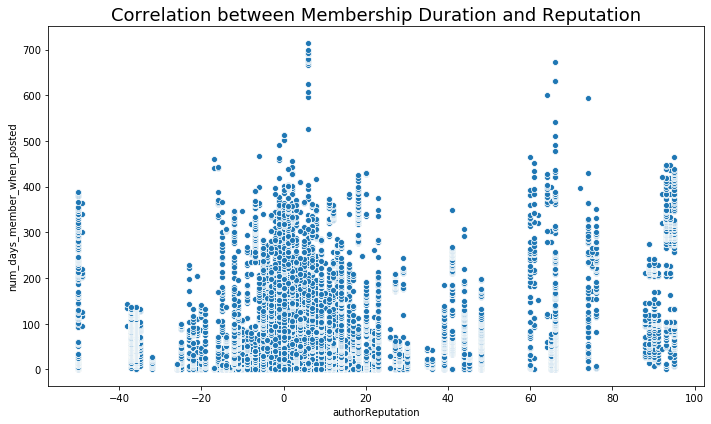

In [20]:
rep_limit = 500
excl_rep_outliers = wallstreet_v2[wallstreet_v2['authorReputation'] < rep_limit]

plt.figure(figsize=(10,6))

sns.scatterplot(y='num_days_member_when_posted', x='authorReputation', data=excl_rep_outliers)
plt.title('Correlation between Membership Duration and Reputation', fontsize=18)
plt.tight_layout();

In [ ]:

max_words=5000
all_lem_tokens =  list(map(str,itertools.chain.from_iterable(list(wallstreet_v2['lemmatized_tokens']))))
#only_letters = lambda x: re.sub(r'[^a-zA-Z]', '', x)
#tokens_alpha = list(map(only_letters, all_lem_tokens))

wordcloud = WordCloud(background_color='white', max_words=max_words, contour_width=3, contour_color='steelblue')
wordcloud.generate(all_lem_tokens)
wordcloud.to_image()

In [50]:
all_lem_tokens = ' '.join(list(wall_nlp['cleaned_v2'])).split(' ')

In [52]:
all_lem_tokens[:-20]

['',
 'just',
 'thought',
 'id',
 'introduce',
 'myself',
 'i',
 'am',
 'new',
 'to',
 'the',
 'communities',
 'and',
 'trying',
 'to',
 'learn',
 'as',
 'much',
 'as',
 'i',
 'can',
 'figured',
 'i',
 'may',
 'as',
 'well',
 'start',
 'here',
 'so',
 'far',
 'i',
 'like',
 'the',
 'simplicity',
 'of',
 'the',
 'site',
 'i',
 'hope',
 'it',
 'does',
 'go',
 'far',
 'im',
 'searching',
 'for',
 'any',
 'tips',
 'on',
 'carding',
 'and',
 'howto',
 'stay',
 'secure',
 'thanks',
 'for',
 'reading',
 'stay',
 'safe',
 '',
 '',
 'hello',
 '',
 'nice',
 'to',
 'see',
 'you',
 'hereregards',
 '',
 '',
 'hello',
 'everyonei',
 'would',
 'like',
 'to',
 'tell',
 'you',
 'that',
 'weve',
 'implemented',
 'new',
 'features',
 'and',
 'fixes',
 'to',
 'get',
 'the',
 'best',
 'experience',
 'with',
 'wsmwe',
 'like',
 'to',
 'hear',
 'feedback',
 'from',
 'you',
 'about',
 'already',
 'implemented',
 'features',
 'but',
 'also',
 'new',
 'ideas',
 'and',
 'criticsits',
 'been',
 'only',
 'a',
 'fe